# Combined approach for Multilabel Binary Classification (MBC) and Regression

We  have two levels of data imbalance:  
  ( Level 1 ) convergene pattern imbalance across meshes (mesh imblance);   
            Example: '000'- 60%, '011' - 30%, '010' - 9%, '100' - 1%
            This causes a problem for classification. Possible solutions - resampling, or weigted entropy loss 

  ( Level 2 ) some solvers rarely converge (solver imbalance); 
            Example: from the example above,  data present for y1 - 1%, y2 - 39%, y3 - 0%
           


Dataset with  mesh-features  
`D:/ML4pmg/Data_Large23/mesh_features.csv `           unbalanced dataset    
`D:/ML4pmg/Data_Large23/balanced_mesh_features.csv `  balanced (by pattern) dataset    

Dataset with mesh and fracture-features  
`D:/ML4pmg/Data_Large4/mesh_features.csv `           unbalanced dataset    
`D:/ML4pmg/Data_Large4/balanced_mesh_features.csv`   balanced (by pattern) dataset    

In [433]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import lightgbm as lgb



In [434]:
df = pd.read_csv("D:/ML4pmg/Data_Large4/mesh_features_annotated.csv")
df.head()

,mesh_name,mesh_id,n_elements,n_nodes,n_fractures,area_mean,area_median,area_std,area_5pct,area_95pct,...,length_max,orientation_mean,orientation_median,orientation_std,orientation_5pct,orientation_95pct,orientation_min,orientation_max,convergence_pattern,pattern_id
0,mesh2d_Xfr_0000.msh,0,11307,5741,48,0.000088,0.000043,0.000135,6.767622e-07,0.000329,...,3.795583,-0.018859,0.770763,1.898441,-2.868408,2.392400,-3.129456,2.974126,1100111100111,5
1,mesh2d_Xfr_0001.msh,1,9734,4957,41,0.000103,0.000058,0.000134,1.539556e-06,0.000368,...,2.142718,0.143106,0.923600,2.016992,-2.951769,2.595133,-3.066049,2.834920,1100111100111,5
2,mesh2d_Xfr_0002.msh,2,19860,10017,53,0.000050,0.000018,0.000106,2.606839e-07,0.000198,...,4.199006,0.870995,1.204647,1.884652,-2.856945,3.035712,-3.136452,3.121978,1000001,2
3,mesh2d_Xfr_0003.msh,3,15268,7720,45,0.000065,0.000024,0.000117,3.149339e-07,0.000282,...,2.114722,0.366699,0.986031,1.877151,-2.470862,2.994755,-3.099135,3.084871,100111000001,1
4,mesh2d_Xfr_0004.msh,4,21710,10925,54,0.000046,0.000007,0.000111,1.556122e-08,0.000222,...,4.597640,0.035577,0.732041,2.154126,-2.912721,2.794167,-3.084889,3.056958,0,0


In [435]:
print(f"Data shape: {df.shape}")
print(*df.columns, sep="\n")

Data shape: (4000, 113)
mesh_name
mesh_id
n_elements
n_nodes
n_fractures
area_mean
area_median
area_std
area_5pct
area_95pct
area_min
area_max
signed_area_mean
signed_area_median
signed_area_std
signed_area_5pct
signed_area_95pct
signed_area_min
signed_area_max
rms_edge_mean
rms_edge_median
rms_edge_std
rms_edge_5pct
rms_edge_95pct
rms_edge_min
rms_edge_max
volume_length_metric_mean
volume_length_metric_median
volume_length_metric_std
volume_length_metric_5pct
volume_length_metric_95pct
volume_length_metric_min
volume_length_metric_max
min_angle_mean
min_angle_median
min_angle_std
min_angle_5pct
min_angle_95pct
min_angle_min
min_angle_max
max_angle_mean
max_angle_median
max_angle_std
max_angle_5pct
max_angle_95pct
max_angle_min
max_angle_max
grading_ratio_mean
grading_ratio_median
grading_ratio_std
grading_ratio_5pct
grading_ratio_95pct
grading_ratio_min
grading_ratio_max
y_time_0
y_time_1
y_time_2
y_time_3
y_time_4
y_time_5
y_time_6
y_time_7
y_time_8
y_time_9
y_time_10
y_time_11
y_tim

## Data pre-processing

-  From the data `X` by extracting the correct columns, form `Yconv` and `Yref`, for classification and regression labels, respectively;    
-  Revomove columns in `Yconv` and `Yreg` that do not carry any information (basically contant throughout the dataset), to obtain `Yc` and `Yr`

In [436]:
# this can be skipped; just to ensure all convergence patterns have the same length (padded with zeros)
expected_length = 18

# Pad with zeros on the left if needed
df['convergence_pattern'] = df['convergence_pattern'].apply(
    lambda x: str(x).zfill(expected_length)
)
# Check that they are correct now
print(df['convergence_pattern'].head())

0    000001100111100111
1    000001100111100111
2    000000000001000001
3    000000100111000001
4    000000000000000000
Name: convergence_pattern, dtype: object


### Forming `X`, `Yconv`, `Yreg`

In [437]:
pattern_col = "convergence_pattern"

time_cols = sorted([c for c in df.columns if c.startswith("y_time_")],
                   key=lambda s: int(s.split("y_time_")[1]))

conv_cols = sorted([c for c in df.columns if c.startswith("y_conv_")],
                   key=lambda s: int(s.split("y_conv_")[1]))

excluded_cols = time_cols + conv_cols + [pattern_col] + ['mesh_name', 'mesh_id','pattern_id']

feature_cols = [c for c in df.columns if c not in excluded_cols]

X = df[feature_cols].values
#Yconv = np.array([list(map(int, s)) for s in df[pattern_col].values], dtype=np.int8)
Yconv = df[conv_cols].values.astype(int)
Yreg =df[time_cols].values

print(f' Dataset X of {X.shape} with classification labels  Yconv of {Yconv.shape} and regression labels Yreg of {Yreg.shape}')

 Dataset X of (4000, 73) with classification labels  Yconv of (4000, 18) and regression labels Yreg of (4000, 18)


In [438]:
Yconv[0,:]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [817]:
Best_of_all = np.argmax(Yr, axis=1)
print(Counter(Best_of_all))

Counter({0: 1407, 1: 770, 2: 751, 4: 543, 3: 285, 8: 219, 6: 13, 5: 10, 7: 2})


### Forming `Yc` and `Yr`

Obtain the statistis of per solver succeseful converngence and display it

In [439]:
N, m = Yconv.shape
solver_stats = []
for j in range(m):
    num_1 = int(Yconv[:, j].sum())
    num_0 = int(N - num_1)

    if num_1 == 0:
        status = "always diverged"
    elif num_0 == 0:
        status = "always converged"
    else:
        status = "mixed"

    solver_stats.append({
        "status": status,
        "num_ones": num_1,
        "num_zeros": num_0,
        "convergence_proportion": num_1 / N
    })

# Convert to DataFrame for inspection
solver_df = pd.DataFrame(solver_stats)
print(solver_df)


             status  num_ones  num_zeros  convergence_proportion
0   always diverged         0       4000                 0.00000
1   always diverged         0       4000                 0.00000
2   always diverged         0       4000                 0.00000
3   always diverged         0       4000                 0.00000
4   always diverged         0       4000                 0.00000
5             mixed       682       3318                 0.17050
6             mixed      1831       2169                 0.45775
7   always diverged         0       4000                 0.00000
8   always diverged         0       4000                 0.00000
9             mixed      1831       2169                 0.45775
10            mixed      1831       2169                 0.45775
11            mixed      2250       1750                 0.56250
12            mixed       321       3679                 0.08025
13  always diverged         0       4000                 0.00000
14  always diverged      

Remove the constant columns, i.e., keep only 'mixed'

In [709]:
aux_mask = solver_df["status"] == "always diverged"
aux_indices = solver_df.index[aux_mask].to_list()

Aux = Yreg[:, aux_indices]


Y_penalty = Aux.max(); T_penalty = np.exp(-Y_penalty)  # back from log-time to time

print(f"Solver indices with divergence: {aux_indices}")
print(f"The max time is set to {Y_penalty:.2f} (log-time) or {T_penalty:.2f} (time)")

Solver indices with divergence: [0, 1, 2, 3, 4, 7, 8, 13, 14]
The max time is set to -1.58 (log-time) or 4.85 (time)


In [819]:
Best_of_all = np.argmax(Yr, axis=1)
print(f'How many times these solvers were the best:')
print(Counter(Best_of_all))

How many times these solvers were the best_
Counter({0: 1407, 1: 770, 2: 751, 4: 543, 3: 285, 8: 219, 6: 13, 5: 10, 7: 2})


In [708]:
T_penalty

4.850165890289308

In [706]:
mixed_mask = solver_df["status"] == "mixed"
mixed_indices = solver_df.index[mixed_mask].to_list()

Yc= Yconv[:,mixed_indices]
Yr = Yreg[:, mixed_indices]

print(f"Solver indices with mixed convergence: {mixed_indices}")
print(f"The classification lavels Yc are of {Yc.shape} and regression labels Yr are of {Yr.shape}")


Solver indices with mixed convergence: [5, 6, 9, 10, 11, 12, 15, 16, 17]
The classification lavels Yc are of (4000, 9) and regression labels Yr are of (4000, 9)


## Split dataset into Train, Validation, and Test 
We need to try and ensure a balance in the split, guided by statistics of the Training Set labels `Yc_tr`. 

There three options below: Multilabel- aware split, Stratified split by number of positives per row, and Random split.  
Control the choice with `choice` selecting between `{'multilabel-aware-split', 'stratified','random'}`


In [441]:
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit as MLSSS

from sklearn.metrics import (
    precision_recall_curve, f1_score, precision_score, recall_score,
    accuracy_score, average_precision_score, roc_auc_score )

In [442]:

def split_data(X, Yc, Yr, choice="multilabel-aware-split", random_state=42):
    """
    Split data into train, validation, and test sets.
    
    Parameters
    ----------
    X : array-like, shape (N, n)
        Feature matrix.
    Yc : array-like, shape (N, m)
        Classification labels (multilabel).
    Yr : array-like, shape (N, m), optional
        Regression labels.
    choice : str
        Split strategy: 'multilabel-aware-split', 'stratified', or 'random'.
    random_state : int
        Random seed.
    
    Returns
    -------
    (X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te)
    """
    if choice == "multilabel-aware-split":
        msss = MLSSS(n_splits=1, test_size=0.2, random_state=random_state)
        trval_idx, te_idx = next(msss.split(X, Yc))

        msss2 = MLSSS(n_splits=1, test_size=0.25, random_state=random_state)
        tr_idx, val_idx = next(msss2.split(X[trval_idx], Yc[trval_idx]))

        tr_idx = trval_idx[tr_idx]
        val_idx = trval_idx[val_idx]

        print("✔ Used multilabel stratified split (train/val/test).")
        return (
        X[tr_idx], X[val_idx], X[te_idx],
        Yc[tr_idx], Yc[val_idx], Yc[te_idx],
        Yr[tr_idx], Yr[val_idx], Yr[te_idx]
    )

    elif choice == "stratified":
        row_sum = Yc.sum(axis=1)
        X_trval, X_te, Yc_trval, Yc_te, Yr_trval, Yr_te = train_test_split(
            X, Yc, Yr, test_size=0.2, stratify=row_sum, random_state=random_state
        )
        strat = row_sum[X_trval.index] if hasattr(X_trval, "index") else None
        X_tr, X_val, Yc_tr, Yc_val, Yr_tr, Yr_val = train_test_split(
            X_trval, Yc_trval, Yr_trval, test_size=0.25, stratify=strat, random_state=random_state
        )
        print("✔ Used stratify by positives count per row (train/val/test).")
        return X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te

    else:
        X_trval, X_te, Yc_trval, Yc_te, Yr_trval, Yr_te = train_test_split(
            X, Yc, Yr, test_size=0.2, random_state=random_state
        )
        X_tr, X_val, Yc_tr, Yc_val, Yr_tr, Yr_val = train_test_split(
            X_trval, Yc_trval, Yr_trval, test_size=0.25, random_state=random_state
        )
        print("⚠️ Used random split (train/val/test, no stratification).")
        return X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te


In [443]:
def make_weights_table(Yc_tr, Yc_val, Yc_te):
    splits = {"train": Yc_tr, "val": Yc_val, "test": Yc_te}
    data = {}

    for split, Y in splits.items():
        pos = Y.sum(axis=0)
        neg = Y.shape[0] - pos
        w   = neg / np.maximum(pos, 1)

        data[(split, "pos")]  = pos
        data[(split, "neg")]  = neg
        data[(split, "scale_pos_weight")] = w

    weights_df = pd.DataFrame(data)
    weights_df.insert(0, ("", "solver_idx"), np.arange(Yc_tr.shape[1]) + 1)
    return weights_df


In [529]:
choice='multilabel-aware-split'
#choice='stratified'
#choice='random'

X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te = split_data(X, Yc, Yr, choice=choice, random_state=42)
print(f"Train: {len(X_tr)} | Val: {len(X_val)} | Test: {len(X_te)}")


weights_df = make_weights_table(Yc_tr, Yc_val, Yc_te)
print(weights_df)





✔ Used multilabel stratified split (train/val/test).
Train: 2400 | Val: 800 | Test: 800
             train                         val                       test  \
  solver_idx   pos   neg scale_pos_weight  pos  neg scale_pos_weight  pos   
0          1   410  1990         4.853659  136  664         4.882353  136   
1          2  1099  1301         1.183803  366  434         1.185792  366   
2          3  1099  1301         1.183803  366  434         1.185792  366   
3          4  1099  1301         1.183803  366  434         1.185792  366   
4          5  1350  1050         0.777778  450  350         0.777778  450   
5          6   193  2207        11.435233   64  736        11.500000   64   
6          7   193  2207        11.435233   64  736        11.500000   64   
7          8   193  2207        11.435233   64  736        11.500000   64   
8          9  1311  1089         0.830664  437  363         0.830664  437   

                         
   neg scale_pos_weight  
0  664      

In [473]:
scale_pos_weights =weights_df['train','scale_pos_weight'].values 
print(scale_pos_weights)

[ 4.79710145  1.19178082  1.19178082  1.19178082  0.77383592 11.5
 11.5        11.5         0.82370821]


## Train with the same parameters for every model, early stopping

In [525]:

m = Yc_tr.shape[1]

clf_models = []

params ={"objective":"binary",
        "n_estimators": 5000, 
        "learning_rate":0.05,
        "max_depth":8,
        "num_leaves":15,
        "min_data_in_leaf":8,
        "max_bin":511,
        "feature_fraction":1.0,
        "bagging_fraction":1.0,
        #verbosity=-1,
        "random_state":24,
        "n_jobs":-1
        }



for j in range(m):
    print(f'Training model for solver {j+1}/{m}...')
    ytr = Yc_tr[:, j]
    clf = lgb.LGBMClassifier(
        **params,
         scale_pos_weight=float(scale_pos_weights[j] ))
    clf.fit(X_tr, ytr,
            eval_set=[(X_val, Yc_val[:, j])],
            eval_metric='average_precision',
            callbacks=[lgb.early_stopping(200, verbose=False)])
    
    clf_models.append(clf)

print("✔ Trained per-solver classifiers.")

Training model for solver 1/9...
Training model for solver 2/9...
Training model for solver 3/9...
Training model for solver 4/9...
Training model for solver 5/9...
Training model for solver 6/9...
Training model for solver 7/9...
Training model for solver 8/9...
Training model for solver 9/9...
✔ Trained per-solver classifiers.


## Selecting best model, needs to be improved

In [868]:

from sklearn.metrics import average_precision_score

m = Yc_tr.shape[1]

clf_models = []
best_params_per_solver = []
best_val_ap_per_solver = []
Ap = np.zeros((n_trials,m))

# --- base (shared) params; candidates will override some of these ---
base_params = {
    "objective": "binary",
    "n_estimators": 5000,
    "learning_rate": 0.05,
    "max_depth": 8,
    "num_leaves": 15,
    "min_data_in_leaf": 8,
    "max_bin": 511,
    "feature_fraction": 1.0,
    "bagging_fraction": 1.0,
    "random_state": 24,
    "n_jobs": -1,
    # keep LightGBM quiet during CV; early_stopping will still work
    "verbose": -1,
}

# --- simple random sampler (you can tweak ranges as needed) ---
rng = np.random.RandomState(24)

def sample_params(rng):
    return {
        # Continuous range
        "learning_rate": rng.uniform(0.01, 0.1),      

        # Discrete integer ranges
        "num_leaves": int(rng.randint(15, 64)),       # 15..63
        "max_depth": int(rng.choice([-1, 6, 8, 10])), # -1 = any depth, controlled by other parameters; 
        "min_data_in_leaf": int(rng.randint(20, 101)), # 20..100
        "max_bin": int(rng.choice([255, 511, 1251])),       # bins usually discrete

        # Continuous fractions
        "feature_fraction": rng.uniform(0.6, 1.0),    
        "bagging_fraction": rng.uniform(0.6, 1.0),    

        # Discrete freq
        "bagging_freq": int(rng.choice([0, 1, 5])),

        # Regularization (continuous)
        "lambda_l1": rng.uniform(0.0, 1.0),           
        "lambda_l2": rng.uniform(0.0, 5.0),           

        # Split gain threshold
        "min_gain_to_split": rng.uniform(0.0, 0.2),   
    }

# how many random tries per solver
n_trials = 20

for j in range(m):
    print(f'Training model for solver {j+1}/{m}...')
    ytr = Yc_tr[:, j]
    yval = Yc_val[:, j]

    best_ap = -1.0
    best_clf = None
    best_params = None

    for t in range(1, n_trials + 1):
        cand = {**base_params, **sample_params(rng)}
        clf = lgb.LGBMClassifier(**cand, scale_pos_weight= 1.0) #=scale_pos_weights[j]
        clf.fit(
            X_tr, ytr,
            eval_set=[(X_val, yval)],
            eval_metric="aucpr", #"binary_logloss",             # threshold-free metric for early stopping
            callbacks=[lgb.early_stopping(200, verbose=False)]
        )

        # Select by validation AP (threshold-free)
        p_val = clf.predict_proba(X_val)[:, 1]
        ap = average_precision_score(yval, p_val)
        Ap[t-1,j]= ap

        if ap > best_ap:
            best_ap = ap
            best_clf = clf
            best_params = cand

        if t % 10 == 0 or t == n_trials:
            print(f"  trial {t}/{n_trials} | best val AP so far: {best_ap:.4f}")

    clf_models.append(best_clf)
    best_params_per_solver.append(best_params)
    best_val_ap_per_solver.append(best_ap)
    print(f"✔ Solver {j+1}: selected model with val AP = {best_ap:.4f}")

print("✔ Trained & selected best per-solver classifiers based on validation AP.")


Training model for solver 1/9...
  trial 10/20 | best val AP so far: 0.7647
  trial 20/20 | best val AP so far: 0.7763
✔ Solver 1: selected model with val AP = 0.7763
Training model for solver 2/9...
  trial 10/20 | best val AP so far: 0.9560
  trial 20/20 | best val AP so far: 0.9560
✔ Solver 2: selected model with val AP = 0.9560
Training model for solver 3/9...
  trial 10/20 | best val AP so far: 0.9560
  trial 20/20 | best val AP so far: 0.9565
✔ Solver 3: selected model with val AP = 0.9565
Training model for solver 4/9...
  trial 10/20 | best val AP so far: 0.9570
  trial 20/20 | best val AP so far: 0.9570
✔ Solver 4: selected model with val AP = 0.9570
Training model for solver 5/9...
  trial 10/20 | best val AP so far: 0.9274
  trial 20/20 | best val AP so far: 0.9274
✔ Solver 5: selected model with val AP = 0.9274
Training model for solver 6/9...
  trial 10/20 | best val AP so far: 0.7372
  trial 20/20 | best val AP so far: 0.7372
✔ Solver 6: selected model with val AP = 0.737

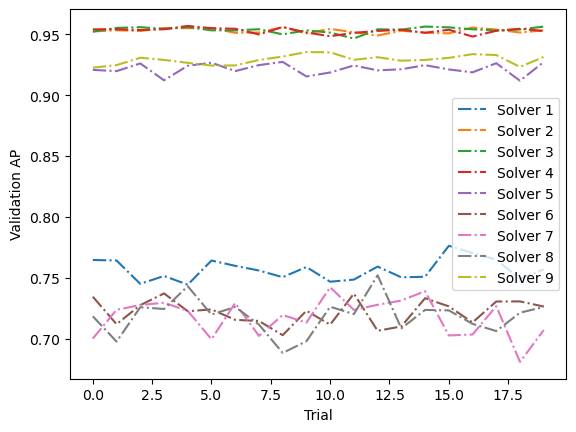

In [869]:
for j in range(Ap.shape[1]):
    plt.plot(Ap[:, j], '-.', label=f"Solver {j+1}")
plt.xlabel("Trial")
plt.ylabel("Validation AP")
plt.legend()
plt.show()

In [831]:
best_params_per_solver[1] 

{'objective': 'binary',
 'n_estimators': 5000,
 'learning_rate': 0.09596281406175713,
 'max_depth': -1,
 'num_leaves': 35,
 'min_data_in_leaf': 61,
 'max_bin': 1251,
 'feature_fraction': 0.8709538999589814,
 'bagging_fraction': 0.854201346436217,
 'random_state': 24,
 'n_jobs': -1,
 'verbose': -1,
 'bagging_freq': 0,
 'lambda_l1': 0.3341661025568635,
 'lambda_l2': 4.851263006098711,
 'min_gain_to_split': 0.0930569767560707}

In [842]:
best_params_per_solver[6] 

{'objective': 'binary',
 'n_estimators': 5000,
 'learning_rate': 0.05753913964504601,
 'max_depth': 6,
 'num_leaves': 43,
 'min_data_in_leaf': 40,
 'max_bin': 511,
 'feature_fraction': 0.6682719683713703,
 'bagging_fraction': 0.7059913003112845,
 'random_state': 24,
 'n_jobs': -1,
 'verbose': -1,
 'bagging_freq': 5,
 'lambda_l1': 0.5169003460522077,
 'lambda_l2': 0.8059362214243582,
 'min_gain_to_split': 0.16042503741369174}

In [843]:
best_val_ap_per_solver

[0.7762815370359963,
 0.9559549963869222,
 0.9564648405649161,
 0.9569921254144543,
 0.9274194572299255,
 0.7371770675512207,
 0.74223829926022,
 0.7520809187546493,
 0.935532985383278]

## Making better model selection for each model, based on the training data balance

## With bagging and scaling, and early stopping

In [530]:

def effective_spw(N_pos, N_neg, pos_frac=1.0, neg_frac=0.4, R_target=1.0):
    P = pos_frac * N_pos
    N = neg_frac * N_neg
    return N / (R_target * P)



def per_solver_params(n_pos, n_neg):
    N = n_pos + n_neg
    r = min(n_pos, n_neg) / N
    # smaller leaves for rare class
    mdil = max(6, int(min(n_pos, n_neg) / (25 if r < 0.10 else 12)))
    leaves = max(31, min(63, N // mdil))
    out = dict(min_data_in_leaf=mdil, num_leaves=leaves, max_depth=8)

    
    if r < 0.30:
        # class-wise subsampling instead of huge weights
        spw = effective_spw(n_pos, n_neg, pos_frac=1.0, neg_frac=0.35)
        print(f'scaling rate is {spw:.1f} for ratio {r:.3f}')
        out.update(dict(
            scale_pos_weight=spw,
            bagging_freq=1,
            pos_bagging_fraction=1.0,
            neg_bagging_fraction=0.35,   # tune 0.2–0.6
            max_bin=1200
        ))
    return out

base = dict(
    objective="binary",
    learning_rate=0.01,           # more trees, smaller steps
    n_estimators=5000,            # rely on early stopping
    lambda_l1=0.0, lambda_l2=0.0,
    random_state=24, n_jobs=-1
)

m = Yc_tr.shape[1]

clf_models = []

for j in range(m):
    p = {**base, **per_solver_params(pos_counts_tr[j], neg_counts_tr[j])}
    ytr = Yc_tr[:, j]
    clf = lgb.LGBMClassifier(**p)
    clf.fit(X_tr, ytr,
            eval_set=[(X_val, Yc_val[:, j])],
            eval_metric='average_precision',
            callbacks=[lgb.early_stopping(200, verbose=False)])
  
    clf_models.append(clf)


scaling rate is 1.6 for ratio 0.181
scaling rate is 3.7 for ratio 0.087
scaling rate is 3.7 for ratio 0.087
scaling rate is 3.7 for ratio 0.087


## With objective function scalinga and early stopping:

In [853]:
def leaf_params(Npos,Nneg, min_data=8, max_leaves_cap=30):
    N = Npos + Nneg
    Nmin = min(Npos, Nneg) # number of minority class samples
    min_data_in_leaf = max(min_data, int(Nmin/20))
    num_leaves = max(15, min(int(N / min_data_in_leaf), max_leaves_cap))
    return min_data_in_leaf, num_leaves

In [854]:
m = Yc_tr.shape[1]

clf_models = []


params = {
    "objective": "binary",
    "n_estimators": 5000,
    "learning_rate": 0.05,
    "max_depth": 8,
    #"num_leaves": 31,
    #"min_split_gain": 0.01,
    #"lambda_l1": 0.1,
    #"lambda_l2": 1.0,
    #"feature_fraction": 0.8,
    #"bagging_fraction": 0.8,
    #"bagging_freq": 1,
    "max_bin": 511,
    "random_state": 24,
    "n_jobs": -1,
    "verbosity": -1, #hide warnings
    "force_col_wise": True   # removes the col-wise hint
}


for j in range(m):
    print(f'Training model for solver {j+1}/{m}...')

    ytr = Yc_tr[:, j]

    # compute per-solver leaf settings
    mdil, nleaves = leaf_params(pos_counts_tr[j], neg_counts_tr[j])
    print(f'number of leaves: {nleaves}, min_data_in_leaf: {mdil}')
    scw =scale_pos_weights[j]
    clf = lgb.LGBMClassifier(
        **params,
         scale_pos_weight=float(scw),
         min_data_in_leaf = mdil, num_leaves =nleaves
         )
    clf.fit(X_tr, ytr,
            eval_set=[(X_val, Yc_val[:, j])],
            eval_metric='average_precision',
            callbacks=[lgb.early_stopping(200, verbose=False)])
    clf_models.append(clf)

print("✔ Trained per-solver classifiers.")

Training model for solver 1/9...
number of leaves: 30, min_data_in_leaf: 21
Training model for solver 2/9...
number of leaves: 30, min_data_in_leaf: 54
Training model for solver 3/9...
number of leaves: 30, min_data_in_leaf: 54
Training model for solver 4/9...
number of leaves: 30, min_data_in_leaf: 54
Training model for solver 5/9...
number of leaves: 30, min_data_in_leaf: 52
Training model for solver 6/9...
number of leaves: 30, min_data_in_leaf: 10
Training model for solver 7/9...
number of leaves: 30, min_data_in_leaf: 10
Training model for solver 8/9...
number of leaves: 30, min_data_in_leaf: 10
Training model for solver 9/9...
number of leaves: 30, min_data_in_leaf: 53
✔ Trained per-solver classifiers.


In [511]:
clf = clf_models[6]

b = clf.booster_.dump_model()
leaves_first_tree = b["tree_info"][0]["num_leaves"]
print(leaves_first_tree)  # should be ≥ 2



28


### EVALUATION

In [844]:
from sklearn.metrics import precision_recall_curve

def best_threshold_from_pr(y_true, y_prob, beta=1.0, target=None):

    """
    Choose threshold from the precision–recall curve.
    - If target is None: maximize F_beta (F1 by default).
    - If target={"precision": p}: meet precision>=p, then maximize recall.
    - If target={"recall": r}: meet recall>=r, then maximize precision.
    Falls back to 0.5 if degenerate.
    """
    if (y_true.min() == y_true.max()) or y_true.sum() == 0:
        return 0.5

    precision, recall, thr = precision_recall_curve(y_true, y_prob)
    # Align arrays: thr has length k; prec/rec have length k+1
    precision, recall = precision[:-1], recall[:-1]
    if thr.size == 0:
        return 0.5

    eps = 1e-12
    if target is None:
        b2 = beta * beta
        fbeta = (1 + b2) * (precision * recall) / (b2 * precision + recall + eps)
        idx = int(np.nanargmax(fbeta))
        return float(thr[idx])

    if "precision" in target:
        mask = precision >= float(target["precision"])
        if np.any(mask):
            cand = np.where(mask)[0]
            idx = cand[int(np.argmax(recall[cand]))]
            return float(thr[idx])
        # otherwise: best achievable precision
        return float(thr[int(np.argmax(precision))])

    if "recall" in target:
        mask = recall >= float(target["recall"])
        if np.any(mask):
            cand = np.where(mask)[0]
            idx = cand[int(np.argmax(precision[cand]))]
            return float(thr[idx])
        # otherwise: best achievable recall
        return float(thr[int(np.argmax(recall))])



 Evaluating the 1 (out of 9) model... 


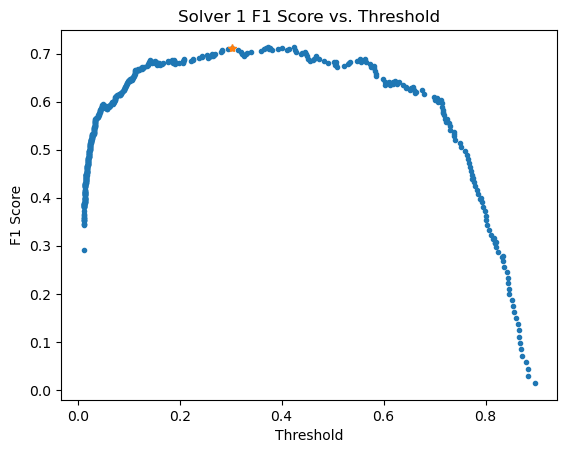

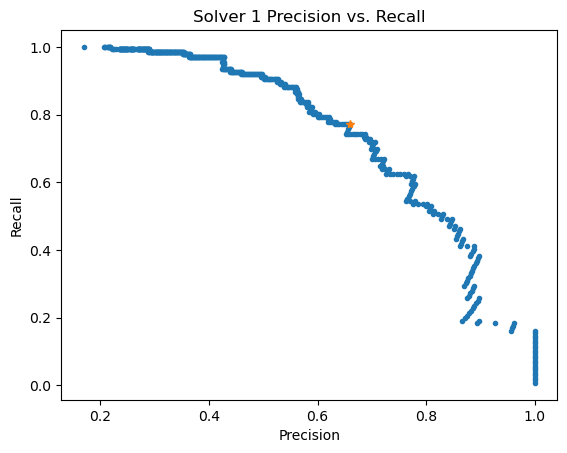

 Evaluating the 2 (out of 9) model... 


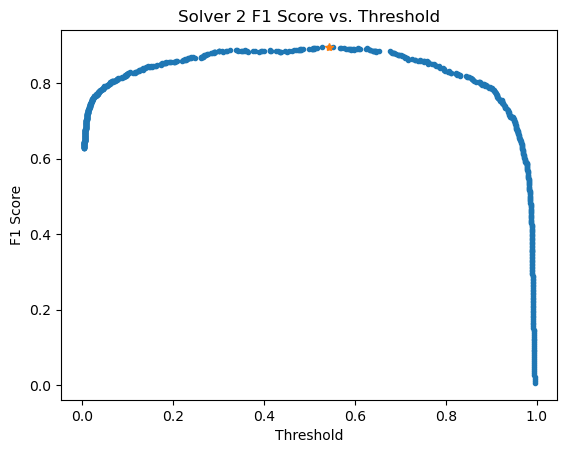

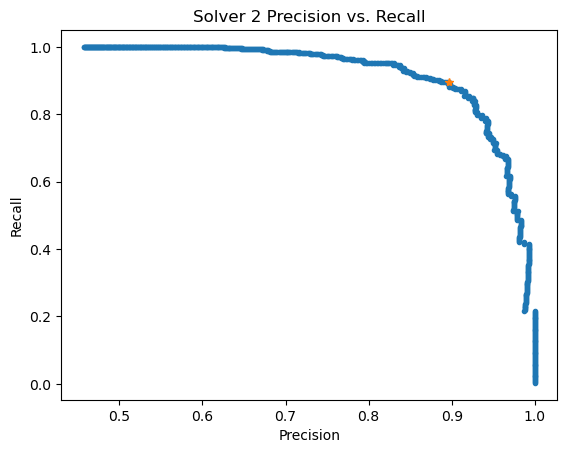

 Evaluating the 3 (out of 9) model... 


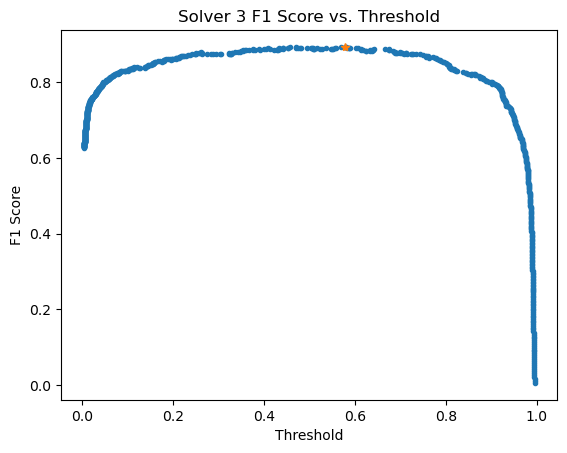

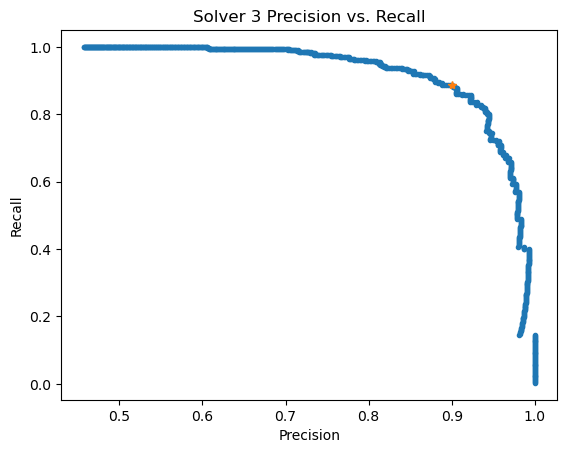

 Evaluating the 4 (out of 9) model... 


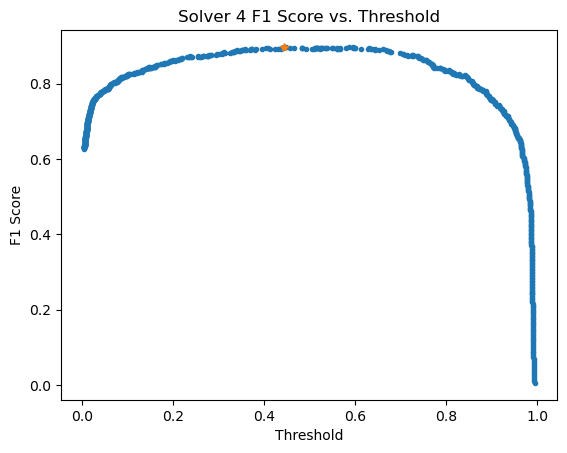

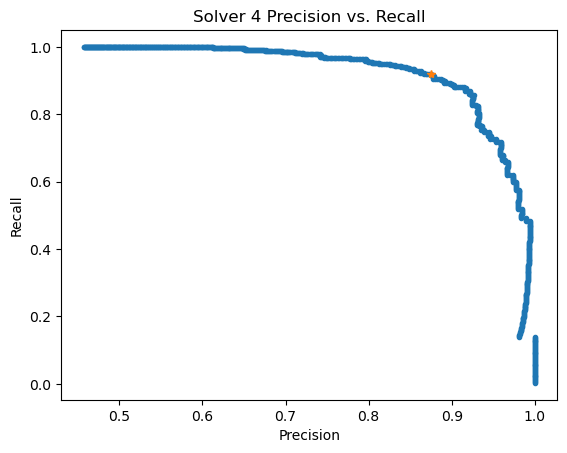

 Evaluating the 5 (out of 9) model... 


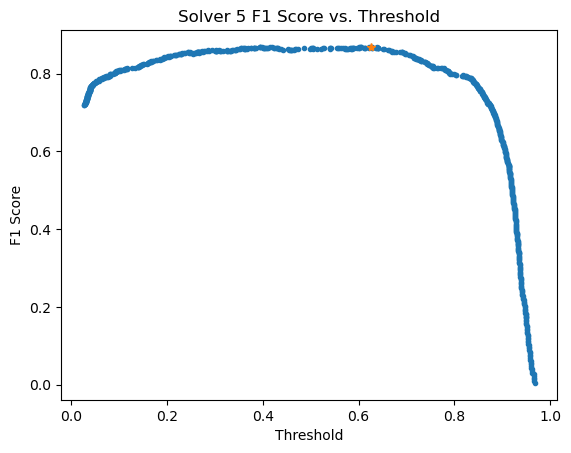

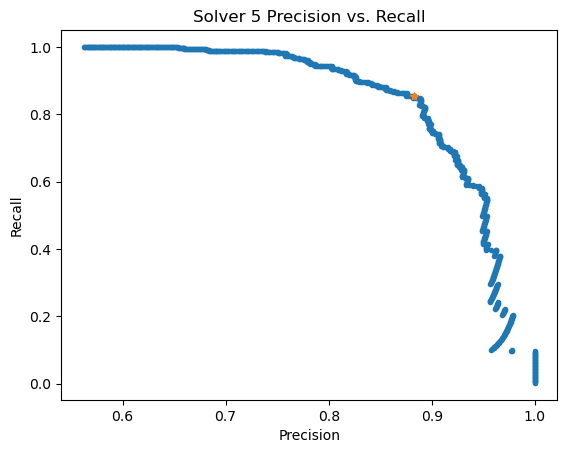

 Evaluating the 6 (out of 9) model... 


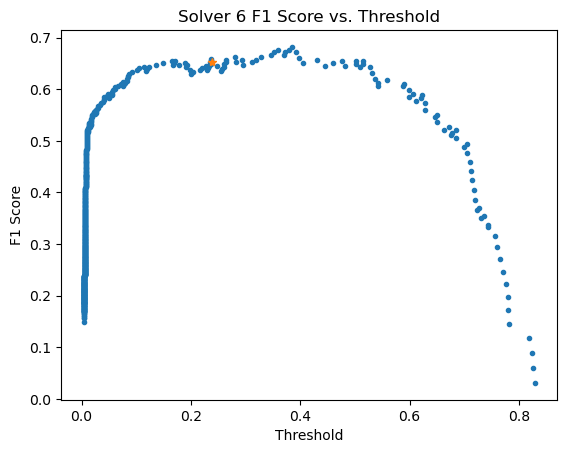

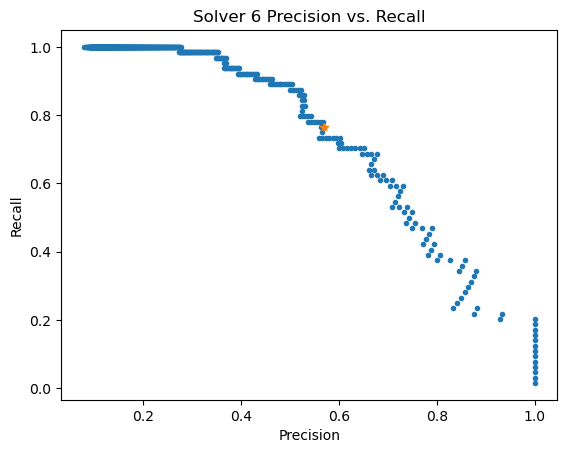

 Evaluating the 7 (out of 9) model... 


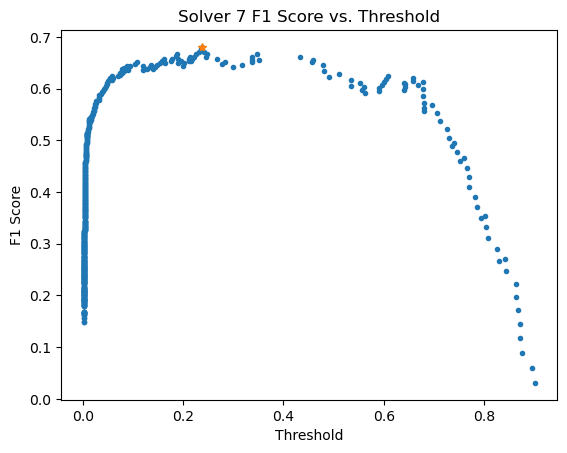

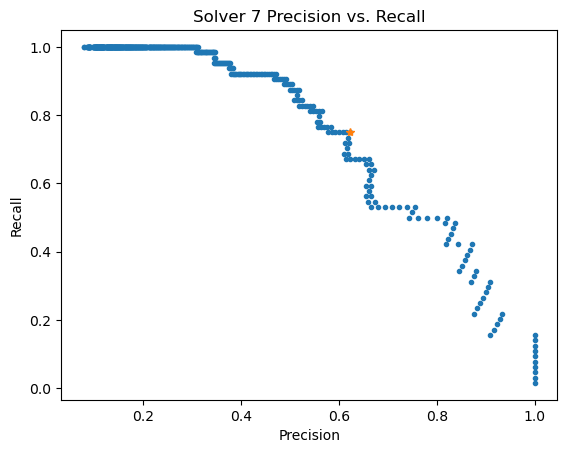

 Evaluating the 8 (out of 9) model... 


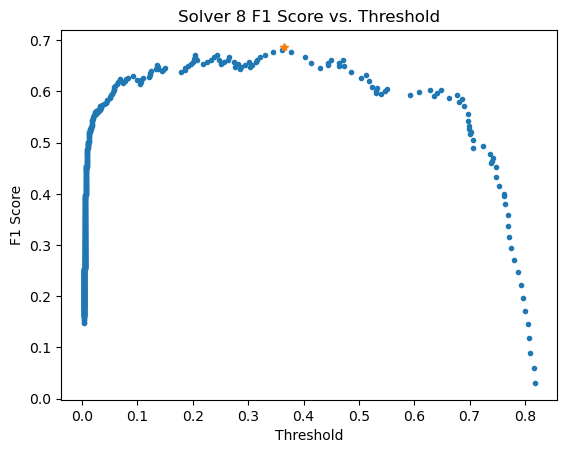

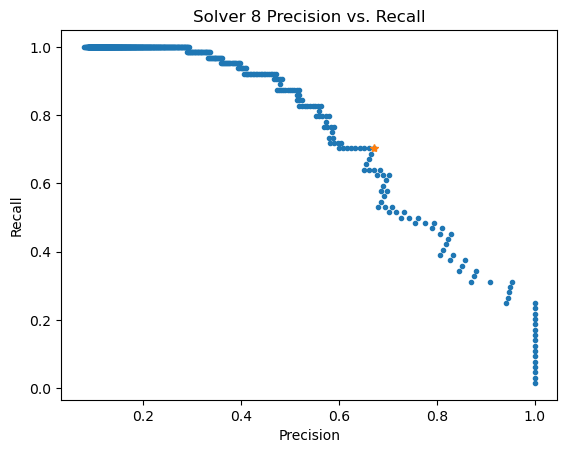

 Evaluating the 9 (out of 9) model... 


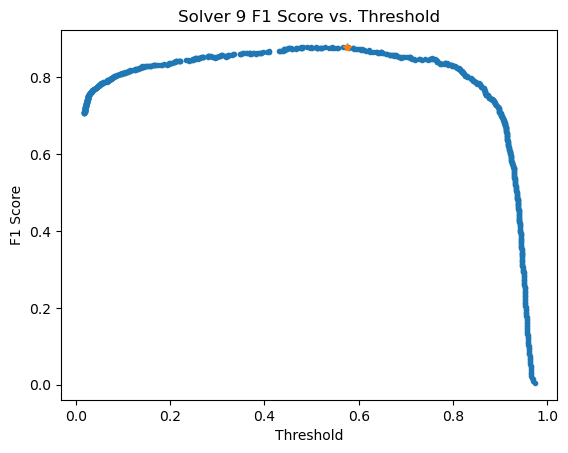

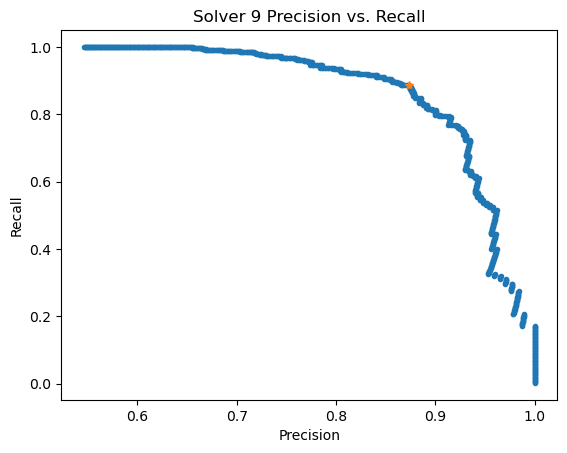

Macro F1 (test, best threshold): 0.803
Macro F1 (test, thr=0.5): 0.803


In [870]:
eps = 1e-12  # to avoid division by zero
beta = 1.0  # for F_beta; beta=1.0 means F1 score

best_thresholds = []
best_f1= []

per_solver_metrics = []
per_solver_metrics_05 = []
Yc_te_pred = np.zeros_like(Yc_te)
Yc_te_pred_05 = np.zeros_like(Yc_te)

prec = weights_df['train','scale_pos_weight'].values
for j, clf in enumerate(clf_models):
    print(f' Evaluating the {j+1} (out of {len(clf_models)}) model... ')
    
    y_val = Yc_val[:, j] # from validation set for threshold tuning
    p_val = clf.predict_proba(X_val)[:, 1]
    if (j==0) or (j==5) or (j==6) &(j==7):
        tag = {'recall': 0.75}
    else: tag = None
    best_t=best_threshold_from_pr(y_val, p_val, beta=beta, target= tag)
    best_thresholds.append(best_t)

    prec, rec, thr = precision_recall_curve(y_val, p_val)
    prec, rec = prec[:-1], rec[:-1]
    b2 = beta * beta
    f1s = (1 + b2) * (prec * rec) / (b2 * prec + rec + eps)

    kj =np.argmin((best_t - thr)**2)
    best_f1.append(f1s[kj])

    plt.plot(thr, f1s,'.')
    plt.plot(thr[kj], f1s[kj],'*')
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"Solver {j+1} F1 Score vs. Threshold")   
    plt.show()

 
    plt.plot(prec, rec,'.')
    plt.plot(prec[kj], rec[kj],'*')
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.title(f"Solver {j+1} Precision vs. Recall")   
    plt.show()

    best_t = thr[int(np.argmax(f1s))]
    #best_thresholds.append(best_t)
    best_f1.append(max(f1s))


    y_true = Yc_te[:, j]
    p_te = clf.predict_proba(X_te)[:, 1]

    
    y_pred_05 = (p_te >= 0.5).astype(int) # predictions at fixed 0.5 threshold
    y_pred = (p_te >= best_t).astype(int) # predictions at best threshold
    
    Yc_te_pred[:, j] = y_pred
    Yc_te_pred_05[:, j] = y_pred_05
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    
    pr_auc = average_precision_score(Yc_te[:, j], p_te)
    roc_auc = roc_auc_score(Yc_te[:, j], p_te)
    f1 = f1_score(Yc_te[:, j], y_pred, zero_division=0)

    per_solver_metrics.append({
        "Solver": j+1,
        "PR_AUC": pr_auc,
        "ROC_AUC": roc_auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Positives": int(y_true.sum()),
        "Negatives": int(len(y_true) - y_true.sum())
    })

    precision = precision_score(y_true, y_pred_05, zero_division=0)
    recall = recall_score(y_true, y_pred_05, zero_division=0)
    acc = accuracy_score(y_true, y_pred_05)

    
    pr_auc = average_precision_score(Yc_te[:, j], p_te)
    roc_auc = roc_auc_score(Yc_te[:, j], p_te)
    f1 = f1_score(Yc_te[:, j], y_pred_05, zero_division=0)

    per_solver_metrics_05.append({
        "Solver": j+1,
        "PR_AUC": pr_auc,
        "ROC_AUC": roc_auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Positives": int(y_true.sum()),
        "Negatives": int(len(y_true) - y_true.sum())
    })


# Macro F1 across solvable labels
macro_f1 = float(np.mean([d["F1"] for d in per_solver_metrics])) 
print(f"Macro F1 (test, best threshold): {macro_f1:.3f}")

per_solver_metrics = pd.DataFrame(per_solver_metrics)



macro_f1_05 = float(np.mean([d["F1"] for d in per_solver_metrics_05])) 
print(f"Macro F1 (test, thr=0.5): {macro_f1:.3f}")

per_solver_metrics_05=pd.DataFrame(per_solver_metrics_05)

In [872]:
per_solver_metrics_05

,Solver,PR_AUC,ROC_AUC,F1,Precision,Recall,Accuracy,Positives,Negatives
0,1,0.814094,0.950390,0.761538,0.798387,0.727941,0.92250,136,664
1,2,0.958091,0.963404,0.882108,0.895775,0.868852,0.89375,366,434
2,3,0.955289,0.960559,0.872576,0.884831,0.860656,0.88500,366,434
3,4,0.957412,0.961780,0.875691,0.885475,0.866120,0.88750,366,434
4,5,0.914976,0.920876,0.886975,0.860125,0.915556,0.86875,450,350
5,6,0.741812,0.974312,0.721311,0.758621,0.687500,0.95750,64,736
6,7,0.749879,0.975204,0.750000,0.750000,0.750000,0.96000,64,736
7,8,0.739434,0.974567,0.730159,0.741935,0.718750,0.95750,64,736
8,9,0.931452,0.928621,0.879733,0.856833,0.903890,0.86500,437,363


In [871]:
per_solver_metrics

,Solver,PR_AUC,ROC_AUC,F1,Precision,Recall,Accuracy,Positives,Negatives
0,1,0.814094,0.950390,0.753521,0.722973,0.786765,0.91250,136,664
1,2,0.958091,0.963404,0.874824,0.901449,0.849727,0.88875,366,434
2,3,0.955289,0.960559,0.860795,0.896450,0.827869,0.87750,366,434
3,4,0.957412,0.961780,0.876011,0.864362,0.887978,0.88500,366,434
4,5,0.914976,0.920876,0.875141,0.886105,0.864444,0.86125,450,350
5,6,0.741812,0.974312,0.728571,0.671053,0.796875,0.95250,64,736
6,7,0.749879,0.975204,0.684211,0.590909,0.812500,0.94000,64,736
7,8,0.739434,0.974567,0.704225,0.641026,0.781250,0.94750,64,736
8,9,0.931452,0.928621,0.873720,0.868778,0.878719,0.86125,437,363


In [847]:
per_solver_metrics

,Solver,PR_AUC,ROC_AUC,F1,Precision,Recall,Accuracy,Positives,Negatives
0,1,0.814094,0.950390,0.753521,0.722973,0.786765,0.91250,136,664
1,2,0.958091,0.963404,0.874824,0.901449,0.849727,0.88875,366,434
2,3,0.955289,0.960559,0.860795,0.896450,0.827869,0.87750,366,434
3,4,0.957412,0.961780,0.876011,0.864362,0.887978,0.88500,366,434
4,5,0.914976,0.920876,0.875141,0.886105,0.864444,0.86125,450,350
5,6,0.741812,0.974312,0.728571,0.671053,0.796875,0.95250,64,736
6,7,0.749879,0.975204,0.684211,0.590909,0.812500,0.94000,64,736
7,8,0.739434,0.974567,0.704225,0.641026,0.781250,0.94750,64,736
8,9,0.931452,0.928621,0.873720,0.868778,0.878719,0.86125,437,363


threshold: 0.239 for best F1: 0.894


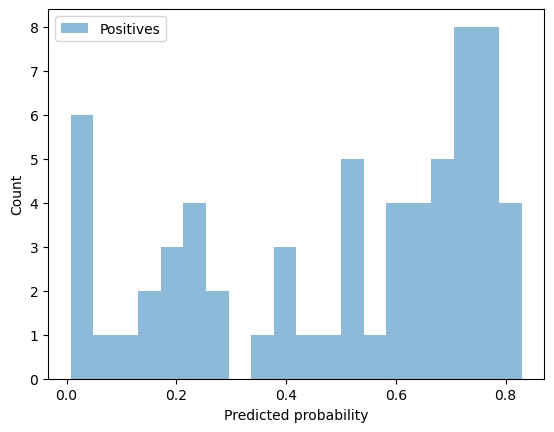

In [873]:
j=5
probs = clf_models[j].predict_proba(X_val)[:,1]  # solver 6 (index 5)
plt.hist(probs[Yc_val[:,j]==1], bins=20, alpha=0.5, label="Positives")
#plt.hist(probs[Yc_val[:,j]==0], bins=20, alpha=0.5, label="Negatives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");
print(f'threshold: {best_thresholds[j]:.3f} for best F1: {best_f1[j]:.3f}')


In [874]:
best_thresholds

[0.3022792157129071,
 0.5437191348622746,
 0.577424824160502,
 0.44264707798624975,
 0.6263951337584884,
 0.23945895761523547,
 0.2367246624349841,
 0.36551144504410116,
 0.5749436417166236]

threshold: 0.239 for best F1: 0.894


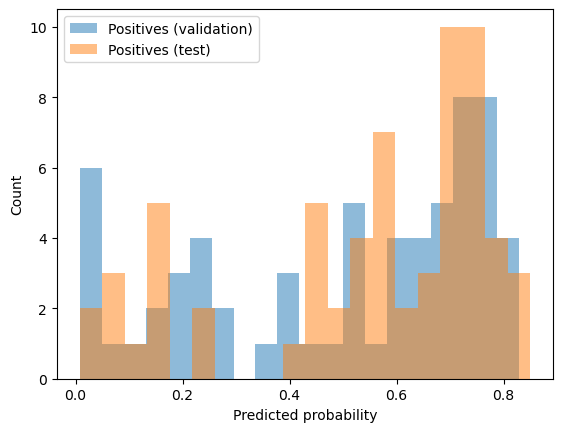

In [875]:
probs_tr = clf_models[j].predict_proba(X_te)[:,1]  # solver 6 (index 5)
plt.hist(probs[Yc_val[:,j]==1], bins=20, alpha=0.5, label="Positives (validation)")
plt.hist(probs_tr[Yc_te[:,j]==1], bins=20, alpha=0.5, label="Positives (test)")
#plt.hist(probs[Yc_val[:,j]==0], bins=20, alpha=0.5, label="Negatives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");
print(f'threshold: {best_thresholds[j]:.3f} for best F1: {best_f1[j]:.3f}')

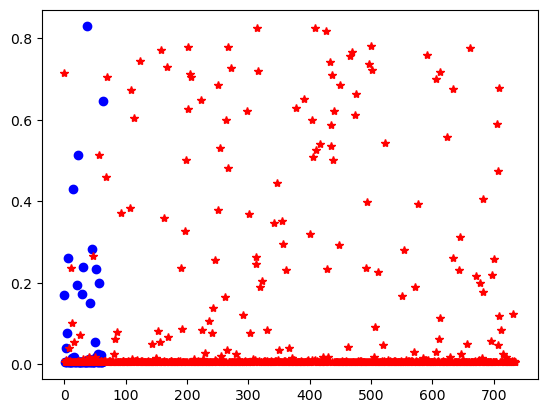

0.004248531717037113


In [876]:
plt.plot(probs[Yc_te[:,j]==1],'bo')
plt.plot(probs[Yc_te[:,j]==0],'*r')
plt.show()
print(min(probs[Yc_te[:,j]==0]))

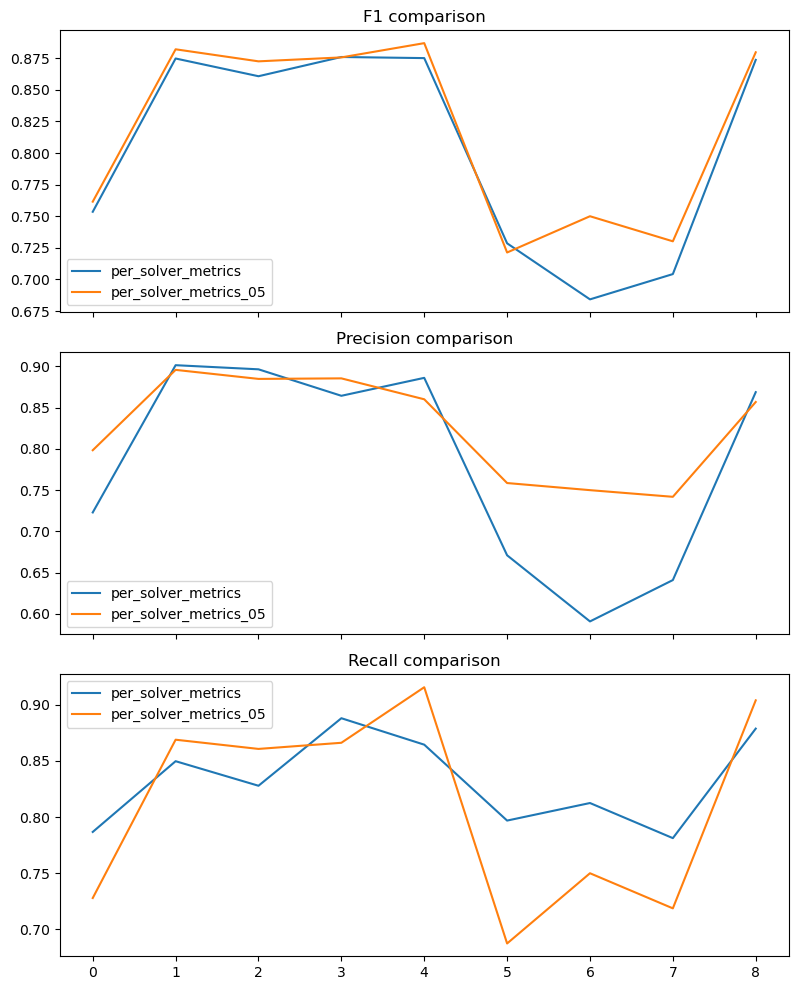

In [877]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# F1
axes[0].plot(per_solver_metrics["F1"], label="per_solver_metrics")
axes[0].plot(per_solver_metrics_05["F1"], label="per_solver_metrics_05")
axes[0].set_title("F1 comparison")
axes[0].legend()

# Precision
axes[1].plot(per_solver_metrics["Precision"], label="per_solver_metrics")
axes[1].plot(per_solver_metrics_05["Precision"], label="per_solver_metrics_05")
axes[1].set_title("Precision comparison")
axes[1].legend()

# Recall
axes[2].plot(per_solver_metrics["Recall"], label="per_solver_metrics")
axes[2].plot(per_solver_metrics_05["Recall"], label="per_solver_metrics_05")
axes[2].set_title("Recall comparison")
axes[2].legend()

plt.tight_layout()
plt.show()

# Regression part

In [889]:
reg_models = []

for j in range(m):
    print(f'Training model for solver {j+1}/{m}...')
    tr_mask = (Yc_tr[:, j] >= 0) # (Yc_tr[:, j] == 0) 
    val_mask = (Yc_val[:, j] >= 0) #(Yc_val[:, j] == 0)


    Xtr_j, ytr_j = X_tr[tr_mask], Yr_tr[tr_mask, j]
    Xval_j, yval_j = X_val[val_mask], Yr_val[val_mask, j]

    
    params_base = dict(objective="regression", learning_rate=0.05, num_leaves=16,
                           min_data_in_leaf=30, feature_fraction=0.8, bagging_fraction=0.8,
                           bagging_freq=5, lambda_l2=1.0, n_estimators=5000)

    # median model
    reg = lgb.LGBMRegressor(**params_base)
    reg.fit(Xtr_j, ytr_j, eval_set=[(Xval_j, yval_j)],
                    eval_metric="l2", callbacks=[lgb.early_stopping(200, verbose=False)])

        
    reg_models.append(reg)
print("✔ Trained per-solver classifiers.")
     
 



Training model for solver 1/9...
Training model for solver 2/9...
Training model for solver 3/9...
Training model for solver 4/9...
Training model for solver 5/9...
Training model for solver 6/9...
Training model for solver 7/9...
Training model for solver 8/9...
Training model for solver 9/9...
✔ Trained per-solver classifiers.


## Trying with the model selection

In [895]:


# ---------------- Regression model selection (per solver) ----------------
m = Yr_tr.shape[1]

reg_models = []
best_params_reg_per_solver = []
best_val_mae_per_solver = []

# --- base (shared) params for regression; candidates override some ---
reg_base_params = {
    "objective": "regression",
    "n_estimators": 5000,
    "learning_rate": 0.05,
    "max_depth": 8,
    "num_leaves": 16,
    "min_data_in_leaf": 30,
    "max_bin": 511,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 1.0,
    "min_gain_to_split": 0.0,
    "random_state": 24,
    "n_jobs": -1,
    "verbose": -1,
}

# --- simple random sampler (same flavor as your clf sampler) ---
rng = np.random.RandomState(24)

def reg_sample_params(rng):
    return {
        "learning_rate": rng.uniform(0.01, 0.1),
        "num_leaves": int(rng.randint(15, 64)),              # 15..63
        "max_depth": int(rng.choice([-1, 6, 8, 10])),
        "min_data_in_leaf": int(rng.randint(20, 101)),       # 20..100
        "max_bin": int(rng.choice([255, 511, 1023, 1251])),
        "feature_fraction": rng.uniform(0.6, 1.0),
        "bagging_fraction": rng.uniform(0.6, 1.0),
        "bagging_freq": int(rng.choice([0, 1, 5])),
        "lambda_l1": rng.uniform(0.0, 1.0),
        "lambda_l2": rng.uniform(0.0, 5.0),
        "min_gain_to_split": rng.uniform(0.0, 0.2),
    }

n_trials = 100  # same search budget as classification

for j in range(m):
    print(f'Training & selecting regression for solver {j+1}/{m}...')

    # Use only rows where solver j converged in that split
    tr_mask  = (Yc_tr[:, j] == 1) 
    val_mask = (Yc_val[:, j] == 1)

    Xtr_j, ytr_j = X_tr[tr_mask],  Yr_tr[tr_mask,  j]  # y is already -log(T)
    Xval_j, yval_j = X_val[val_mask], Yr_val[val_mask, j]

    best_mae = np.inf
    best_reg = None
    best_params = None

    # If no validation positives exist, we still fit but can’t select by val metric
    has_val = (len(yval_j) > 0)

    for t in range(1, n_trials + 1):
        cand = {**reg_base_params, **reg_sample_params(rng)}
        reg = lgb.LGBMRegressor(**cand)

        if has_val:
            reg.fit(
                Xtr_j, ytr_j,
                eval_set=[(Xval_j, yval_j)],
                eval_metric="l1",                          # stable for y = -log(T)
                callbacks=[lgb.early_stopping(200, verbose=False)],
            )
            # validation prediction & MAE in y-space
            yhat_val = reg.predict(Xval_j)
            mae = mean_absolute_error(yval_j, yhat_val)
        else:
            # Fit without eval set; compute MAE via CV proxy is overkill—accept first good model
            reg.fit(Xtr_j, ytr_j)
            mae = np.inf  # no basis to compare → keep the first trained model later if needed

        if mae < best_mae:
            best_mae = mae
            best_reg = reg
            best_params = cand

        if t % 10 == 0 or t == n_trials:
            msg = f"  trial {t}/{n_trials} | best val MAE so far: {best_mae:.4f}" if has_val else f"  trial {t}/{n_trials}"
            print(msg)

    # Fallback if no validation data: ensure we keep *some* model
    if best_reg is None:
        best_reg = reg
        best_params = cand
        best_mae = np.nan

    reg_models.append(best_reg)
    best_params_reg_per_solver.append(best_params)
    best_val_mae_per_solver.append(best_mae)
    if has_val:
        print(f"✔ Solver {j+1}: selected reg model with val MAE = {best_mae:.4f}")
    else:
        print(f"✔ Solver {j+1}: selected reg model (no val positives; MAE=N/A)")

print("✔ Trained & selected best per-solver regressors based on validation MAE.")


Training & selecting regression for solver 1/9...
  trial 10/100 | best val MAE so far: 0.1216
  trial 20/100 | best val MAE so far: 0.1216
  trial 30/100 | best val MAE so far: 0.1216
  trial 40/100 | best val MAE so far: 0.1214
  trial 50/100 | best val MAE so far: 0.1214
  trial 60/100 | best val MAE so far: 0.1214
  trial 70/100 | best val MAE so far: 0.1201
  trial 80/100 | best val MAE so far: 0.1201
  trial 90/100 | best val MAE so far: 0.1201
  trial 100/100 | best val MAE so far: 0.1201
✔ Solver 1: selected reg model with val MAE = 0.1201
Training & selecting regression for solver 2/9...
  trial 10/100 | best val MAE so far: 0.1161
  trial 20/100 | best val MAE so far: 0.1153
  trial 30/100 | best val MAE so far: 0.1153
  trial 40/100 | best val MAE so far: 0.1153
  trial 50/100 | best val MAE so far: 0.1153
  trial 60/100 | best val MAE so far: 0.1153
  trial 70/100 | best val MAE so far: 0.1153
  trial 80/100 | best val MAE so far: 0.1144
  trial 90/100 | best val MAE so far

In [1013]:
print(Yr_te[30,:])
print(Yc_te[30,:]) 

[1.09580609 1.75166364 1.46217402 1.6750907  1.05285136 1.70387453
 1.69472186 1.50453279 1.13949693]
[1 1 1 1 1 1 1 1 1]


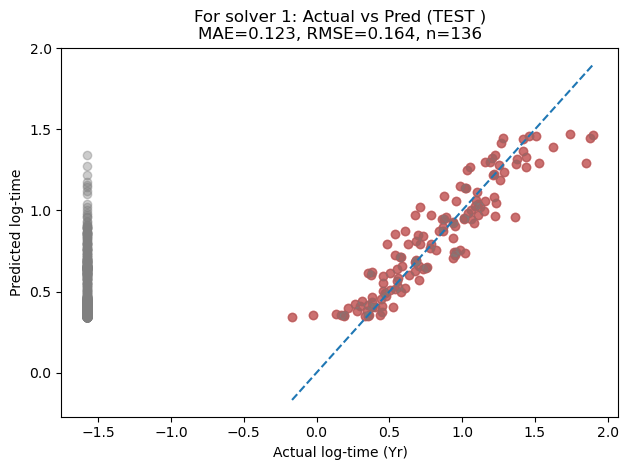

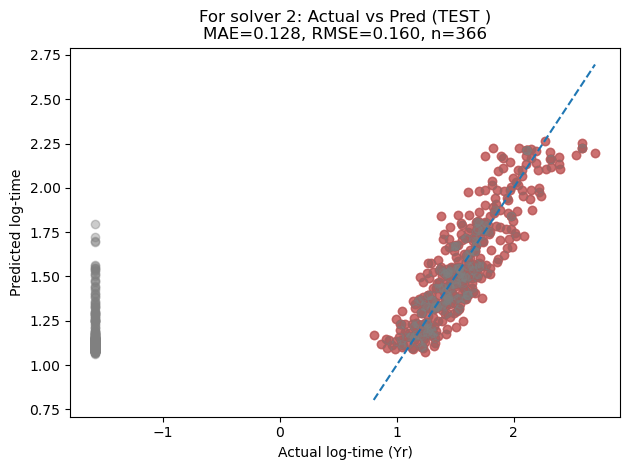

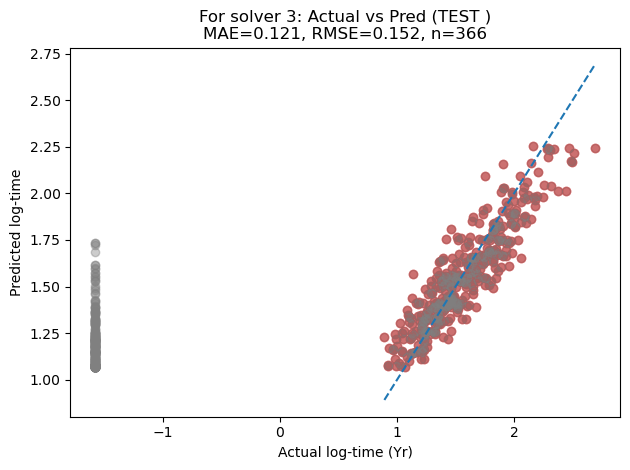

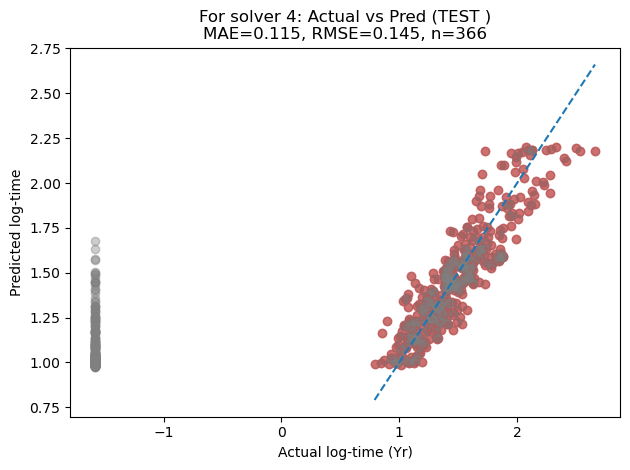

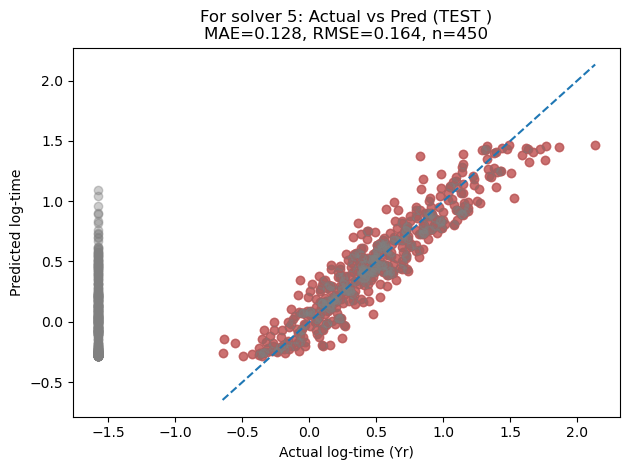

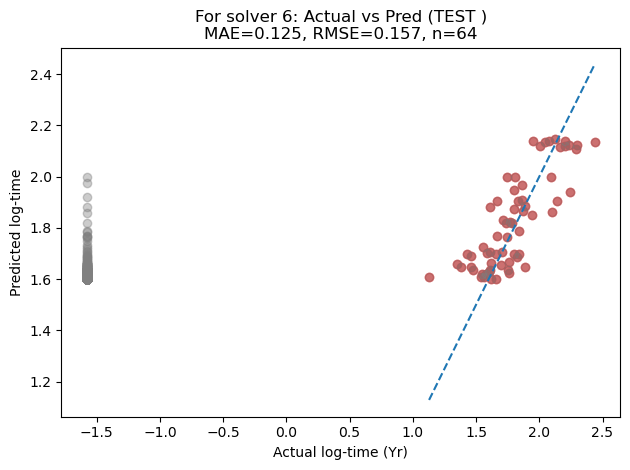

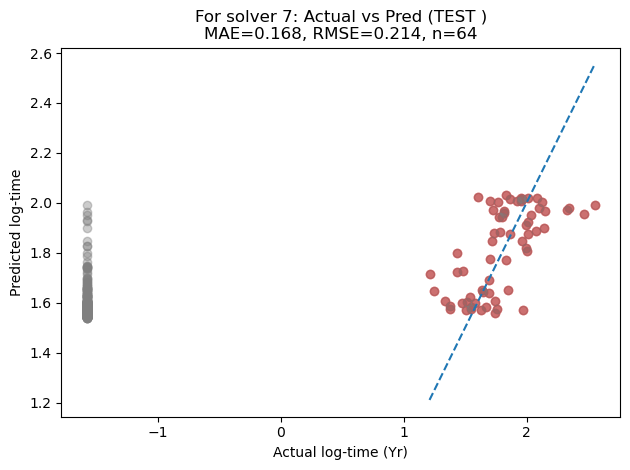

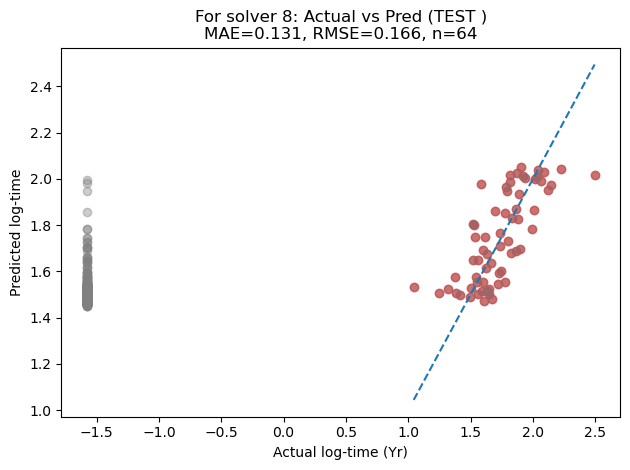

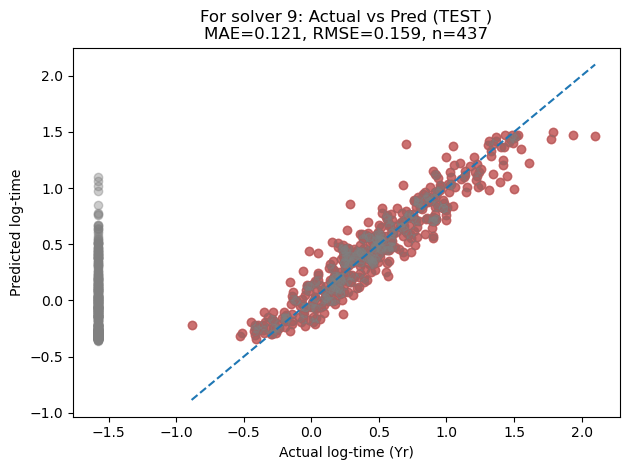


 Per-solver regression metrics (TEST):


,solver,n_test_conv,mae,rmse
0,1,136,0.123291,0.163606
1,2,366,0.127552,0.159518
2,3,366,0.120510,0.152383
3,4,366,0.115437,0.145024
4,5,450,0.127787,0.164158
5,6,64,0.124886,0.157073
6,7,64,0.168357,0.213529
7,8,64,0.130766,0.166371
8,9,437,0.121408,0.159374


In [896]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

results = []

for j in range(m):
        
    te_mask = (Yc_te[:, j] == 1)
    y_true = Yr_te[:, j]
    y_true_masked = Yr_te[te_mask, j]

    yhat = reg_models[j].predict(X_te); y_pred_masked = yhat[te_mask]
    
    mae = mean_absolute_error(y_true_masked, y_pred_masked)
    rmse = mean_squared_error(y_true_masked, y_pred_masked, squared=False)

    results.append({
            "solver": j+1,
            "n_test_conv": int(te_mask.sum()),
            "mae": mae,
            "rmse": rmse            
        })

        # --- Plots ---
       
    plt.figure()
    plt.scatter(y_true_masked, y_pred_masked, alpha=0.6, color='red')  # converged points in blue
    plt.scatter(y_true, yhat, alpha=0.4, color='gray')  # all points in gray
    lo, hi = min(y_true_masked.min(), y_pred_masked.min()), max(y_true_masked.max(), y_pred_masked.max())
    plt.plot([lo, hi], [lo, hi], linestyle="--")  # y = x
    plt.xlabel("Actual log-time (Yr)")
    plt.ylabel("Predicted log-time")
    plt.title(f"For solver {j+1}: Actual vs Pred (TEST )\n"
                  f"MAE={mae:.3f}, RMSE={rmse:.3f}, n={te_mask.sum()}")
    plt.tight_layout()
    plt.show()

 

df = pd.DataFrame(results)
print("\n Per-solver regression metrics (TEST):")
display(df)  





In [1078]:

N, m = Yr_te.shape


Yr_pred = np.zeros((N, m), dtype=float)
T_pred = np.zeros((N, m), dtype=float)

Yc_pred = np.zeros((N, m), dtype=float)
P_pred = np.zeros((N, m), dtype=float)

for j in range(m):
    P_pred[:,j] = clf_models[j].predict_proba(X_te)[:,1]; 
    #Yc_pred[:,j] = (P_pred[:,j]>best_thresholds[j]) # Hard thresholding
    Yc_pred[:,j] = (P_pred[:,j]>0.5) # Hard thresholding
    
    Yr_pred[:, j] = reg_models[j].predict(X_te); T_pred[:, j] = np.exp(-Y_pred[:, j])  # back from log-time to time

softETy = P_pred  * Yr_pred + (1.0 - P_pred)*Y_penalty   # Soft, in log form, (N, m)    
softETt = P_pred  * T_pred + (1.0 - P_pred)* T_penalty   # Soft, in time (seconds), (N, m)

hardETy = Yc_pred  * Yr_pred + (1.0 - Yc_pred)* Y_penalty   # Hard, in log form, (N, m)    
hardETt = Yc_pred  * T_pred + (1.0 - Yc_pred)* T_penalty   # Hard, in time (seconds), (N, m)




In [1079]:


true_best = np.argmax(Yr_te, axis=1);  row_all_zero_true = (Yc_te.sum(axis=1) == 0) # and the mask of rows with at least one converged solver
true_best[row_all_zero_true] = -1  # mark no-solution rows as -1
chosen = np.argmax(hardETy, axis=1); row_all_zero_pred = (Yc_pred.sum(axis=1) == 0)
chosen[row_all_zero_pred] = -1  # mark no-solution rows as -1

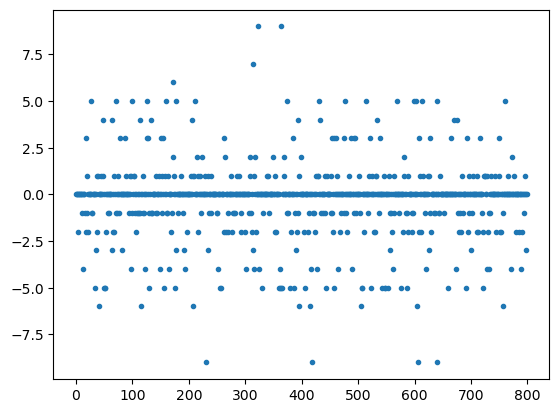

In [1081]:
plt.plot(chosen - true_best,'.')
plt.show()

In [1082]:
def mask_the_chosen(Yc, chosen):
    row_all_zero = (Yc.sum(axis=1) == 0)   
    chosen[row_all_zero] = -1
    return chosen


def failure_rate(Yc_true, Yr_true, chosen, label=""):
    N = len(chosen)

    true_best = mask_the_chosen(Yc_true,np.argmax(Yr_true, axis=1))  # (N,)
   
    #TEST = sum(Yc_true[i, true_best[i]] == 0 for i in range(N)  if true_best[i]>=0)
    #print(f"{label:15s} |  True best solver fails in {TEST}/{N} = {TEST/N:.3f} of cases.")  
   

    FP=sum(Yc_true[i, chosen[i]] == 0 for i in range(N) if chosen[i]>=0)  # predicted best fails (False Positives)
    FN= sum(1 for i in range(N) if chosen[i]==-1 and true_best[i]>=0)  # predicted no-solution but true best exists (False Negaties)
    num_failures = FP + FN;
    fr = num_failures / N
        
    
    aux = chosen - true_best
    num_agreed = np.sum(aux== 0); agr = num_agreed / N 
    num_incorr = N - num_agreed - num_failures; inc = num_incorr / N
    
    print(f"{label:15s} |  Correct best solver choice: {agr:.3f} ({num_agreed}/{N}); Wrong as failed: {fr:.3f} (({FP}+{FN})/{N}), and incorrect: {inc:.3f} ({num_incorr}/{N})") 
    #print(f'Total sum check: {num_agreed + num_failures + num_incorr} = {N}')
    return agr, fr, inc
    

In [1083]:
row_all_zero = (Yc_te.sum(axis=1) == 0)   # boolean mask of length N
row_not_zero = (Yc_te.sum(axis=1) > 0)   # boolean mask of length N
true_best = np.argmax(Yr_te, axis=1)  # (N,)
true_best[row_all_zero] = -1
#valid_mask = (true_best != -1)
TEST = sum(Yc_te[i, true_best[i]] == 0 for i in range(N) if row_not_zero[i])
print(TEST)



0


In [1021]:
k=2
print(true_best[k], Yc_te[k,:], Yr_te[k,:])

0 [0 0 0 0 0 0 0 0 0] [-1.57901291 -1.57901291 -1.57901291 -1.57901291 -1.57901291 -1.57901291
 -1.57901291 -1.57901291 -1.57901291]


In [1085]:


def fastest_of_topk(Yr, Yc, P, k=3):
    N, m = Yr.shape
    chosen = np.zeros(N, dtype=int)
    for i in range(N):
        topk = np.argsort(P[i])[-k:]  # indices of top-k probabilities
        best_in_topk = topk[np.argmax(Yr[i, topk])]  # among them, pick the one with highest Yr
        chosen[i] = best_in_topk
    chosen=mask_the_chosen(Yc,chosen)
    return chosen




strategies = {
    "softETy argmax": lambda: mask_the_chosen(Yc_pred,np.argmax(softETy, axis=1)),
    "softETt argmin": lambda: mask_the_chosen(Yc_pred,np.argmin(softETt, axis=1)),
    "hardETy argmax": lambda: mask_the_chosen(Yc_pred,np.argmax(hardETy, axis=1)),
    "hardETt argmin": lambda: mask_the_chosen(Yc_pred,np.argmin(hardETt, axis=1)),
    "Top 3 argmax":   lambda: fastest_of_topk(Yr_pred, Yc_pred, P_pred, k=2),
    "Score (Tr/P)":  lambda: mask_the_chosen(Yc_pred,np.argmin(hardETt/P_pred**1.6, axis=1)),
        }

# --- loop over them ---
for name, fn in strategies.items():
    chosen = fn()
    failure_rate(Yc_te, Yr_te, chosen, label=name)

softETy argmax  |  Correct best solver choice: 0.522 (418/800); Wrong as failed: 0.151 ((74+47)/800), and incorrect: 0.326 (261/800)
softETt argmin  |  Correct best solver choice: 0.507 (406/800); Wrong as failed: 0.142 ((67+47)/800), and incorrect: 0.350 (280/800)
hardETy argmax  |  Correct best solver choice: 0.550 (440/800); Wrong as failed: 0.150 ((73+47)/800), and incorrect: 0.300 (240/800)
hardETt argmin  |  Correct best solver choice: 0.570 (456/800); Wrong as failed: 0.151 ((74+47)/800), and incorrect: 0.279 (223/800)
Top 3 argmax    |  Correct best solver choice: 0.546 (437/800); Wrong as failed: 0.134 ((60+47)/800), and incorrect: 0.320 (256/800)
Score (Tr/P)    |  Correct best solver choice: 0.540 (432/800); Wrong as failed: 0.152 ((75+47)/800), and incorrect: 0.307 (246/800)


correctly predicted is 0.899 
Counter({0: 472, 1: 107, 2: 96, 3: 90, 4: 23, 5: 9, 6: 3})
472/800 rows matched exactly.
[0. 1. 1. 1. 1. 0. 0. 0. 1.]
[0. 1. 1. 1. 1. 0. 0. 0. 1.]


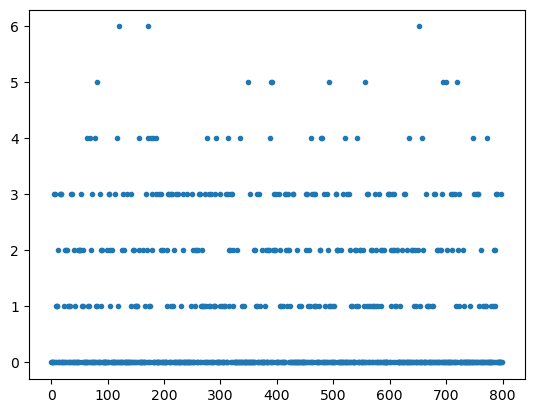

In [949]:
#plt.plot(P_pred - Yc_te,'*r')

corpr=np.sum((Yc_pred - Yc_te) ==0) / (N*m)
print(f'correctly predicted is {corpr:.3f} ' )

row_match = np.all(Yc_pred == Yc_te, axis=1)

hamming_dist = np.sum(Yc_pred != Yc_te, axis=1) # Hamming distance per row


plt.plot(hamming_dist,'.')
print(Counter(hamming_dist))

# Count how many rows matched
num_matched = np.sum(row_match)
print(f"{num_matched}/{len(row_match)} rows matched exactly.")


print(Yc_pred[1,:])
print(1.*Yc_te[1,:])

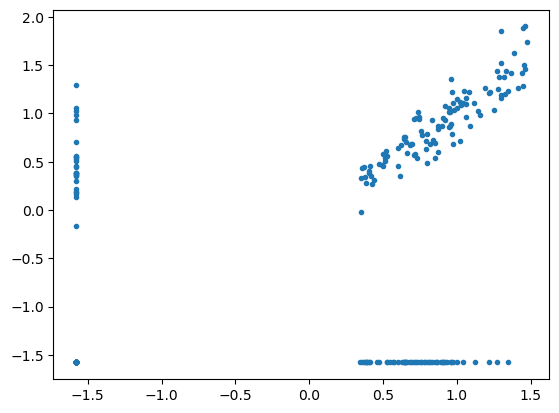

In [950]:
#plt.plot(T_pred[:,8],  Yr_te[:,8],'.')
plt.plot(ETy[:,0],  Yr_te[:,0],'.')
plt.show()

Counter({-1: 271, 2: 153, 1: 144, 4: 127, 3: 63, 8: 33, 6: 4, 0: 3, 5: 2})
Counter({-1: 282, 2: 173, 1: 172, 4: 110, 8: 39, 3: 24})


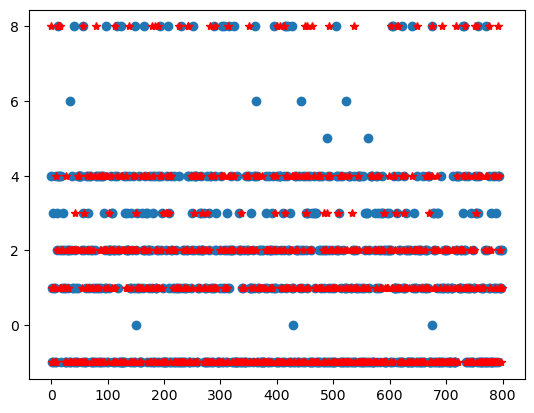

In [1086]:
plt.plot(true_best, 'o')
plt.plot(chosen, '*r')
print(Counter(true_best))
print(Counter(chosen))

In [952]:
aux =chosen - true_best

agreed = np.sum(aux== 0)/len(aux)
wrong = 1 - agreed


print(f' Correct best solver choice: {agreed:.3f}, wrong: {wrong:.3f}')

 Correct best solver choice: 0.552, wrong: 0.448
